## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample
import seaborn as sns 
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
25909,00006808_031.png,No Finding,31,6808,38,F,AP,2500,2048,0.171000,0.171000,NaN,/kaggle/input/data/images_004/images/00006808_...
106891,00028849_001.png,No Finding,1,28849,56,F,PA,2021,2021,0.194311,0.194311,NaN,/kaggle/input/data/images_012/images/00028849_...
24755,00006503_000.png,Effusion,0,6503,60,M,PA,2500,2048,0.171000,0.171000,NaN,/kaggle/input/data/images_003/images/00006503_...


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(vargs, test_size=0.2, stratify=vargs["Pneumonia"])
    # balance data based on real life statistics
    p_ind = train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    np_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    np_sample = sample(np_ind,len(p_ind))
    train_data = train_data.loc[p_ind + np_sample]
    vp_ind = val_data[val_data['pneumonia_class'] == 'Positive'].index.tolist()
    vn_ind = val_data[val_data['pneumonia_class'] == 'Negative'].index.tolist()
    vn_sample = sample(vn_ind, 4*len(vp_ind))
    val_data = val_data.loc[vp_ind+vn_sample]
    
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)


In [7]:
train_data['pneumonia_class'].value_counts()

pneumonia_class
Positive    1145
Negative    1145
Name: count, dtype: int64

In [8]:
val_data['pneumonia_class'].value_counts()


pneumonia_class
Negative    1144
Positive     286
Name: count, dtype: int64

In [9]:
train_data['Patient Gender'].value_counts()


Patient Gender
M    1346
F     944
Name: count, dtype: int64

/tmp/ipykernel_42/3305089035.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['Patient Age'],color='green')
/tmp/ipykernel_42/3305089035.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(female_cases,color='blue')
/tmp/ipykernel_42/3305089035.py:5: UserWarning: 

`distplot` is a 

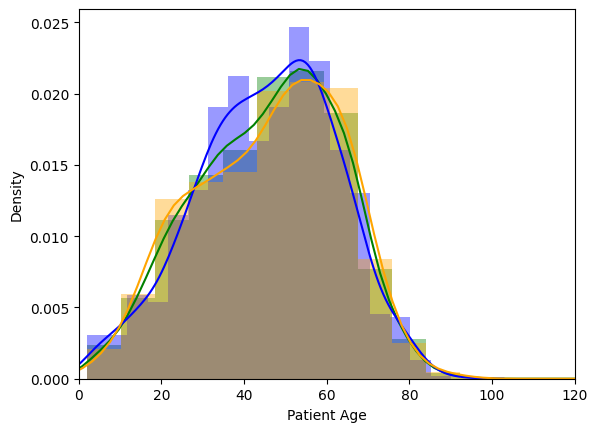

45.98733624454148


In [10]:
female_cases = train_data[train_data['Patient Gender']=='F']['Patient Age']
male_cases = train_data[train_data['Patient Gender']=='M']['Patient Age']
sns.distplot(train_data['Patient Age'],color='green')
sns.distplot(female_cases,color='blue')
sns.distplot(male_cases,color='orange')
plt.xlim(0,120)
plt.savefig('/kaggle/working/training_age_stats.png')
plt.show()
print(str(np.mean(train_data['Patient Age'])))

/tmp/ipykernel_42/1079847697.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val_data['Patient Age'],color='green')
/tmp/ipykernel_42/1079847697.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v_female_cases,color='blue')
/tmp/ipykernel_42/1079847697.py:5: UserWarning: 

`distplot` is a 

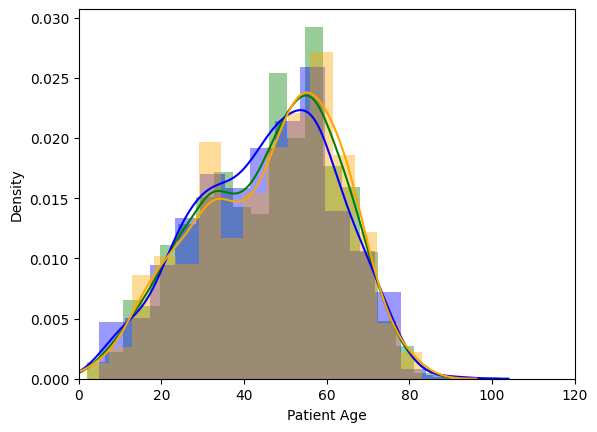

45.87762237762238


In [11]:
v_female_cases = val_data[val_data['Patient Gender']=='F']['Patient Age']
v_male_cases = val_data[val_data['Patient Gender']=='M']['Patient Age']
sns.distplot(val_data['Patient Age'],color='green')
sns.distplot(v_female_cases,color='blue')
sns.distplot(v_male_cases,color='orange')
plt.savefig('/kaggle/working/validation_age_stats.png')
plt.xlim(0,120)
plt.show()
print(str(np.mean(val_data['Patient Age'])))

In [12]:
train_data['View Position'].value_counts()


View Position
PA    1209
AP    1081
Name: count, dtype: int64

In [13]:
val_data['View Position'].value_counts()


View Position
PA    811
AP    619
Name: count, dtype: int64

In [14]:
train_data['path']

48796     /kaggle/input/data/images_006/images/00012364_...
63992     /kaggle/input/data/images_007/images/00015799_...
63342     /kaggle/input/data/images_007/images/00015646_...
55435     /kaggle/input/data/images_007/images/00013894_...
64071     /kaggle/input/data/images_007/images/00015809_...
                                ...                        
64227     /kaggle/input/data/images_007/images/00015843_...
1201      /kaggle/input/data/images_001/images/00000301_...
107144    /kaggle/input/data/images_012/images/00028903_...
54645     /kaggle/input/data/images_006/images/00013670_...
26458     /kaggle/input/data/images_004/images/00006948_...
Name: path, Length: 2290, dtype: object

The validation dataset accuractely reflects the desired 80-20 split of non-pneumonia and pneumonia xray data. The train data also has a rougly 57% to 43% male to female split of data which aligns with the overall dataset's split from the EDA. The patient age distribution overall and by gender matches up with that of the overall dataset from the EDA and the mean patient age is 46 (rounded here) and in the EDA it was 47. We can see that the training dataset has a roughly 52.6% to 47.4% PA to AP View Position xray data split and the validation dataset has a similar 57.1% to 42.9% PA to AP View Position xray data split. This matches the overall dataset's 60 to 40 percent PA to AP View Position split from the EDA.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(
        rescale = 1. /255.0,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = 20, 
        shear_range = 0.1,
        zoom_range = 0.1,
        samplewise_center = True,
        samplewise_std_normalization = True
        
    )
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 16
                                         )

    return train_gen


def make_val_gen(vargs):
    val_idg=ImageDataGenerator(rescale=1. / 255.0
                                 )
    
    
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 32) 
    
    # Todo
    return val_gen

In [16]:
idg = my_image_augmentation(train_data)
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

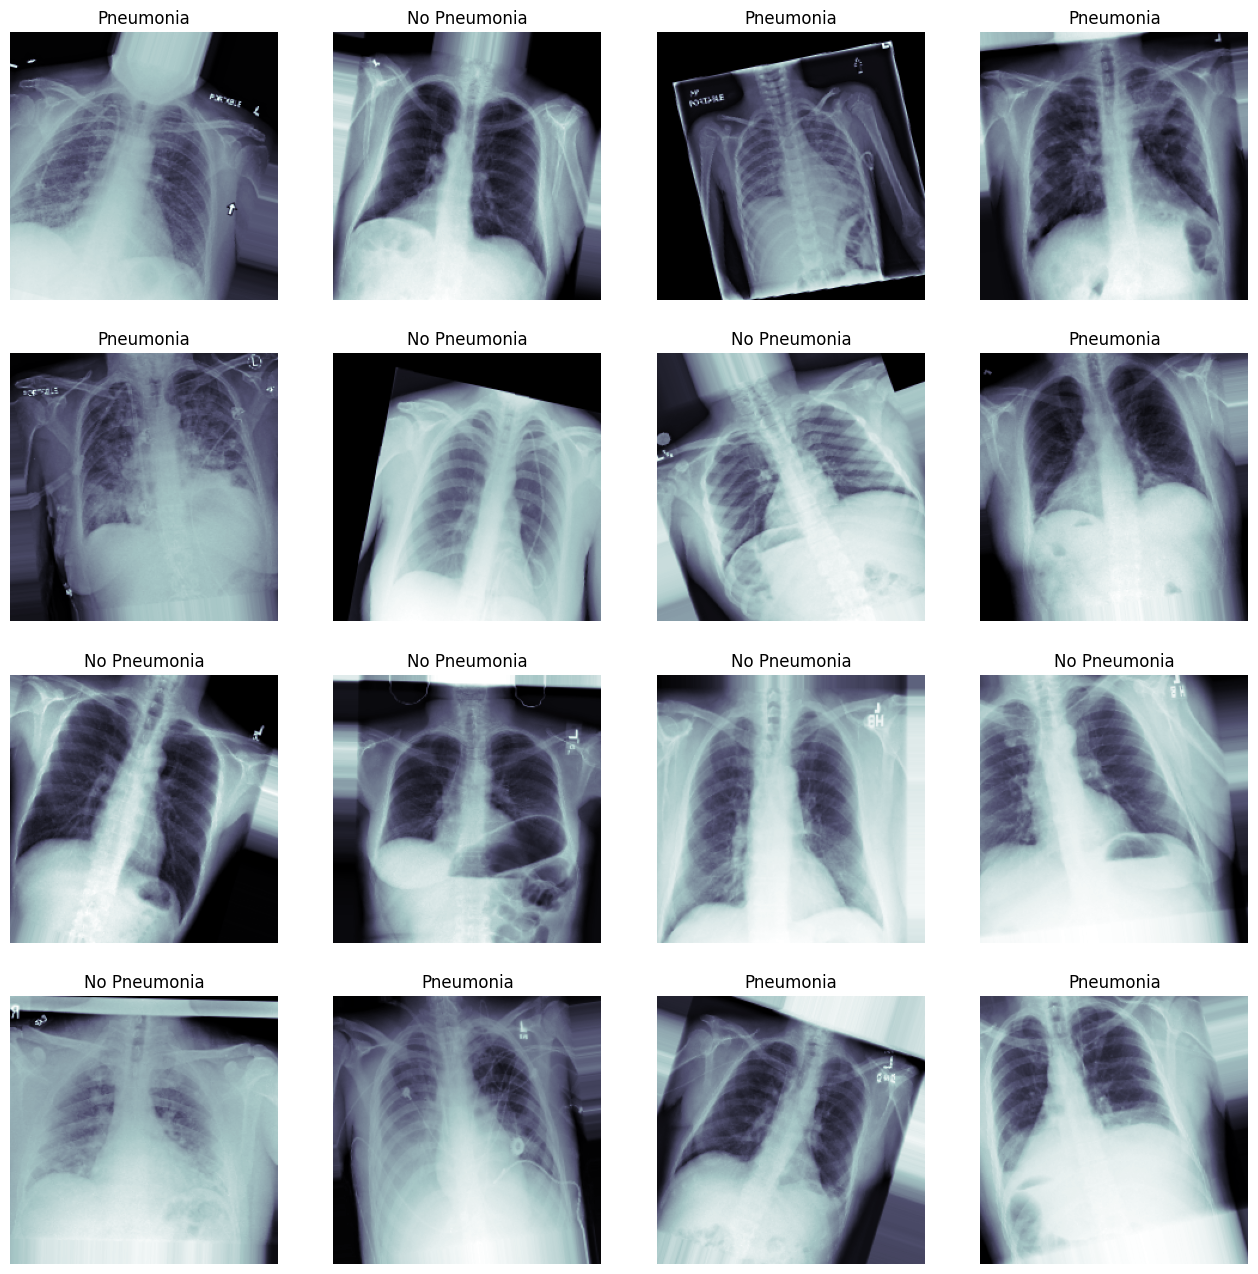

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers:
        layer.trainable = False 
    
    return vgg_model


In [20]:
def build_my_model(vargs):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(16, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(1, activation='sigmoid'))
    
    
                       
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
vgg_model = load_pretrained_model()

553467096/553467096 [==============================] - 3s 0us/step


In [22]:
model = build_my_model(vgg_model)

In [23]:
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [24]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "binary_accuracy", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "max", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "binary_accuracy", 
                      mode= "max", 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [25]:
## train your model

# Todo

history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

/tmp/ipykernel_42/84295912.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/10
144/144 [==============================] - ETA: 0s - loss: 0.7733 - binary_accuracy: 0.5214
Epoch 1: binary_accuracy improved from -inf to 0.52140, saving model to xray_class_my_model.best.hdf5
144/144 [==============================] - 728s 5s/step - loss: 0.7733 - binary_accuracy: 0.5214 - val_loss: 0.7025 - val_binary_accuracy: 0.2500
Epoch 2/10
144/144 [==============================] - ETA: 0s - loss: 0.7206 - binary_accuracy: 0.5114
Epoch 2: binary_accuracy did not improve from 0.52140
144/144 [==============================] - 722s 5s/step - loss: 0.7206 - binary_accuracy: 0.5114 - val_loss: 0.6743 - val_binary_accuracy: 0.7500
Epoch 3/10
144/144 [==============================] - ETA: 0s - loss: 0.7075 - binary_accuracy: 0.5306
Epoch 3: binary_accuracy improved from 0.52140 to 0.53057, saving model to xray_class_my_model.best.hdf5
144/144 [==============================] - 723s 5s/step - loss: 0.7075 - binary_accuracy: 0.5306 - val_loss: 0.6930 - val_binary_accuracy:

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [39]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights('/kaggle/working/xray_class_my_model.best.hdf5')
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 9s 9s/step


In [40]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import sklearn.model_selection as skl

In [42]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import sklearn.model_selection as skl


# from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score
def plot_roc(t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label = 1)
#    np.append(thresholds, 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red',label='Chance', alpha=.8)
    plt.savefig('/kaggle/working/ROC_Curve.png')
    plt.show()
    
    return fpr, tpr, thresholds

def plot_auc(t_y, p_y):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.style.use('ggplot')
    fpr, tpr, thresholds = plot_roc(t_y, p_y)
    res = auc(fpr, tpr)
    return fpr, tpr, thresholds, res
    

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y, p_y, pos_label=1)
    treshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.savefig('/kaggle/working/precision-recall-curve')
    plt.show()
    return precision, recall, threshold 


def calc_f1(p,r):
    return 2*(p[:-1]*r[:-1])/(p[:-1]+r[:-1])


def plot_f1(t_y, p_y):
    print(len(t_y))
    print(len(p_y))
    precision, recall, threshold = precision_recall_curve(t_y, p_y, pos_label=1)
    print(str(len(precision)))
    print(str(len(recall)))
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    print(len(threshold))
    print(len(f1))
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.savefig('/kaggle/working/F1-Threshold-Curve')
    plt.show()
    return precision, recall, threshold, f1

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history, epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch), history.history['loss'], label='Loss', color='green')
    plt.plot(range(epoch), history.history['val_loss'], label='Validation_Loss', color='red')
    plt.plot(range(epoch), history.history['binary_accuracy'], label='Binary_Accuracy', color='blue')
    plt.plot(range(epoch), history.history['val_binary_accuracy'], label='Validation_Bin_Accuracy', color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('/kaggle/working/training_performance')
    plt.show()
    # Todo
    return

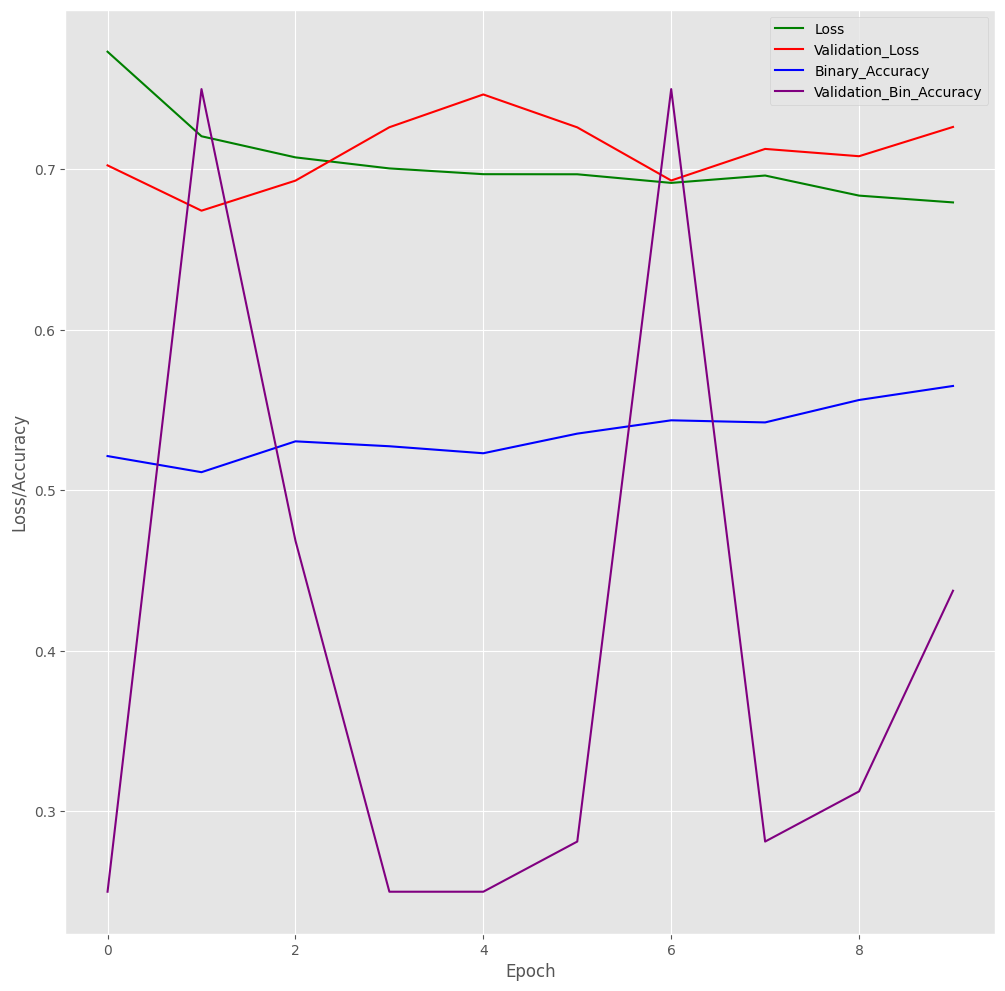

In [43]:
plot_history(history, 10)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

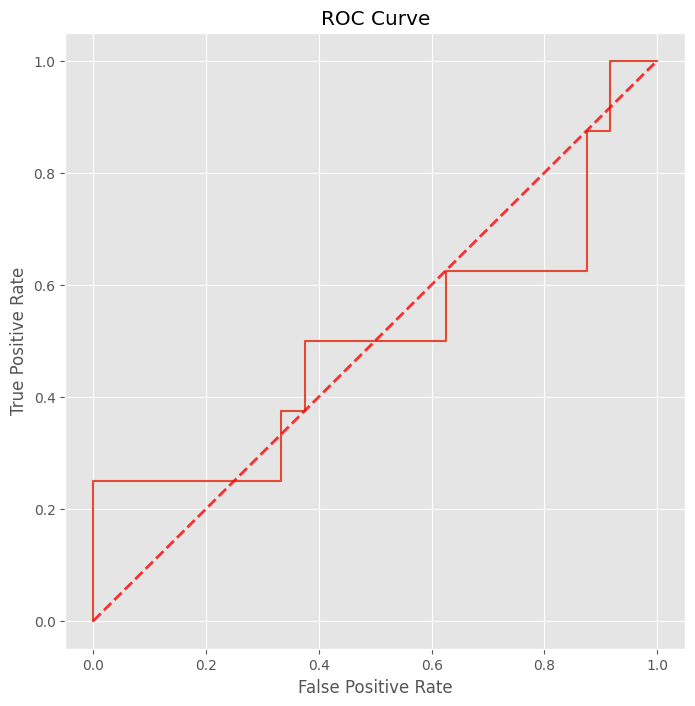

AUC: 0.5


In [44]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
fpr, tpr, thresholds_ROC, AUC = plot_auc(valY, pred_Y)
print(f"AUC: {AUC}")
# Todo

In [45]:
print(f"THRESHOLDS ROC: {thresholds_ROC}")

THRESHOLDS ROC: [1.5869498  0.5869498  0.5823432  0.56026405 0.55880857 0.55720884
 0.55706066 0.5102021  0.5035496  0.49968743 0.49963257 0.496878
 0.49442104 0.4933447  0.49221218 0.45287448]


32
32
31
31
30
30


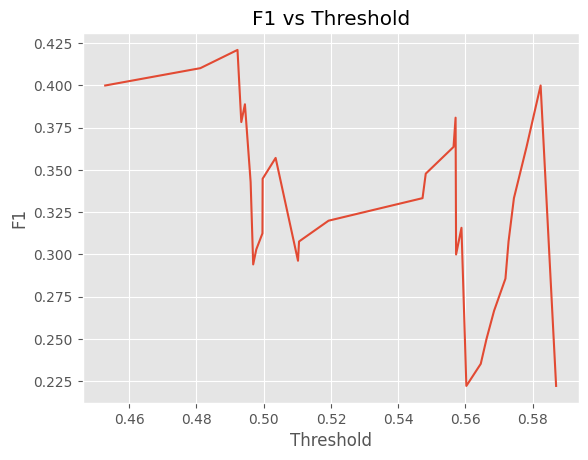

In [46]:
precision, recall, thresholds_f1, f1 = plot_f1(valY, pred_Y)

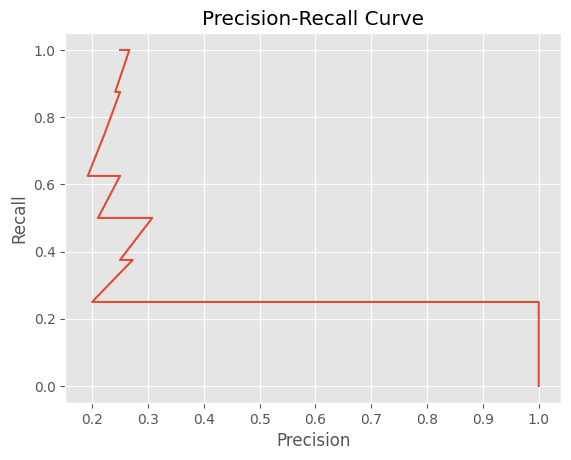

(array([0.25      , 0.25806452, 0.26666667, 0.24137931, 0.25      ,
        0.22222222, 0.19230769, 0.2       , 0.20833333, 0.23809524,
        0.25      , 0.21052632, 0.22222222, 0.23529412, 0.25      ,
        0.26666667, 0.28571429, 0.30769231, 0.25      , 0.27272727,
        0.2       , 0.22222222, 0.25      , 0.28571429, 0.33333333,
        0.4       , 0.5       , 0.66666667, 1.        , 1.        ,
        1.        ]),
 array([1.   , 1.   , 1.   , 0.875, 0.875, 0.75 , 0.625, 0.625, 0.625,
        0.625, 0.625, 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
        0.375, 0.375, 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.25 ,
        0.25 , 0.25 , 0.125, 0.   ]),
 array([0.45287448, 0.48116106, 0.49221218, 0.4933447 , 0.49442104,
        0.49611786, 0.496878  , 0.4978052 , 0.49963257, 0.49968743,
        0.5035496 , 0.5102021 , 0.5105133 , 0.5192859 , 0.5472326 ,
        0.5481896 , 0.5564475 , 0.55706066, 0.55720884, 0.55880857,
        0.56026405, 0.56454307, 0.5662512 , 0.5

In [47]:
plot_precision_recall_curve(valY, pred_Y)


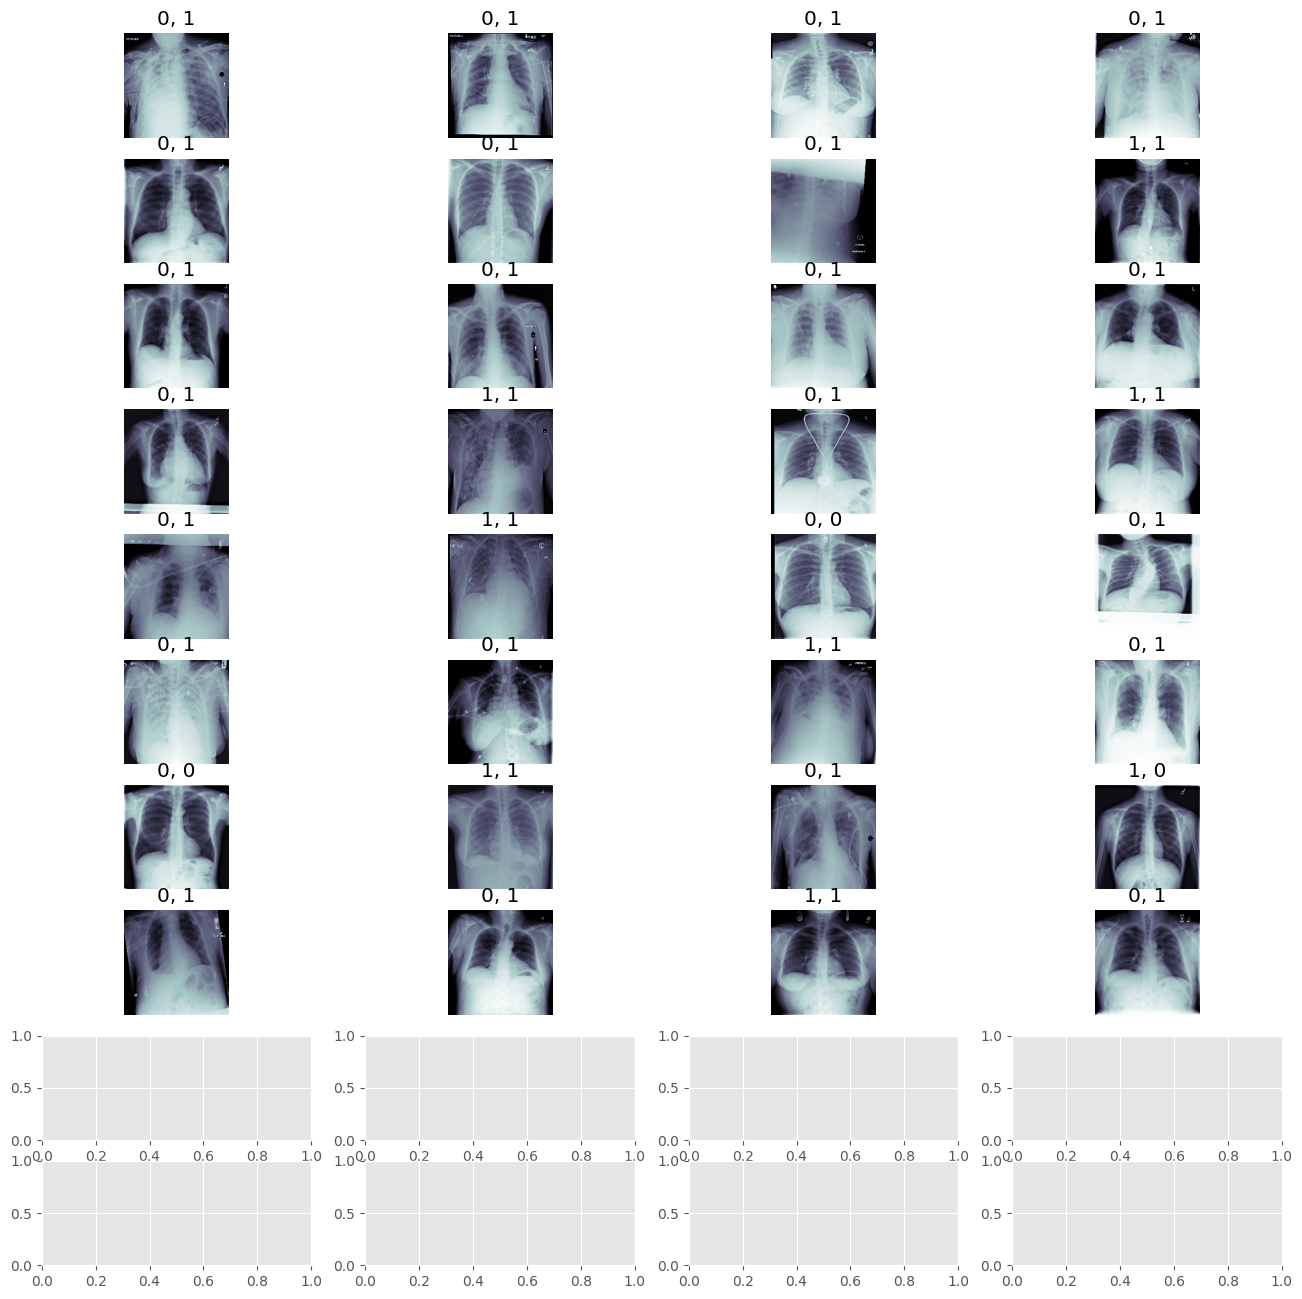

In [67]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10,4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [48]:
eval_df  = pd.DataFrame({"Precision":precision[:-1], "Threshold":thresholds_f1, "Recall":recall[:-1], "F1":f1})
eval_df.head(eval_df.size)

,Precision,Threshold,Recall,F1
0,0.250000,0.452874,1.000,0.400000
1,0.258065,0.481161,1.000,0.410256
2,0.266667,0.492212,1.000,0.421053
3,0.241379,0.493345,0.875,0.378378
4,0.250000,0.494421,0.875,0.388889
5,0.222222,0.496118,0.750,0.342857
6,0.192308,0.496878,0.625,0.294118
7,0.200000,0.497805,0.625,0.303030
8,0.208333,0.499633,0.625,0.312500
9,0.238095,0.499687,0.625,0.344828


The optimal threshold should reflect a balance between recall and precision represented by the maximized f1 score. 

In [52]:
threshold  = eval_df['Threshold'][np.argmax(eval_df['F1'])]
print(f"Chosen Threshold: {threshold}")

Chosen Threshold: 0.492212176322937


In [71]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("/kaggle/working/my_model.json", "w") as json_file:
    json_file.write(model_json)
    
print("DOME")

DOME
